In [1]:
import os
import sys
from collections import OrderedDict

In [2]:
sys.path.append('../..')

In [3]:
import spatialpy
spatialpy.__file__

'../../spatialpy/__init__.py'

In [4]:
import matplotlib.pyplot as plt
import numpy

# Global Constants
MAX_X_DIM = 5.0
MIN_X_DIM = -5.0
TOL = 1e-9

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
class Edge1(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return abs(x[0] - MAX_X_DIM) < 0.05
class Edge2(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return abs(x[0] - MIN_X_DIM) < 0.05
class Middle(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return abs(x[0] - MIN_X_DIM) >= 0.05

In [49]:
class cylinderDemo3D(spatialpy.Model):
    def __init__(self, model_name="cylinder_demo3d"):
        spatialpy.Model.__init__(self, model_name)

        self.timestep_size = 1
        
        # System constants
        D_const = 0.1

        # Define Species
        A = spatialpy.Species(name="A", diffusion_constant=D_const)
        B = spatialpy.Species(name="B", diffusion_constant=D_const)
        self.add_species([A, B])

        # Define Geometry
        self.mesh = spatialpy.Mesh.read_xml_mesh('cylinder.xml')

        # Define Subdomains
        self.set_type(Middle(), 1)
        self.set_type(Edge1(),  2)
        self.set_type(Edge2(),  3)
        
        # Restrict the movement of Chemical Species
        self.restrict(A,[1,2])
        self.restrict(B,[1,3])

        vol = self.mesh.get_vol()
        print("vol",vol)
        type = self.mesh.type
        left = numpy.sum(vol[type == 2])
        right = numpy.sum(vol[type == 3])
        print("left "+str(left)+" right "+str(right))
        
        k_react = spatialpy.Parameter(name="k_react", expression=1.0)
        k_creat1 = spatialpy.Parameter(name="k_creat1", 
                                     expression=100/left)
        k_creat2 = spatialpy.Parameter(name="k_creat2", 
                                     expression=100/right)
        self.add_parameter([k_react, k_creat1,k_creat2])


        # Define Reactions
        R1 = spatialpy.Reaction(reactants=None, products={A:1}, 
                                rate=k_creat1, restrict_to=2)
        R2 = spatialpy.Reaction(reactants=None, products={B:1}, 
                              rate=k_creat2, restrict_to=3)
        R3 = spatialpy.Reaction(reactants={A:1, B:1}, products=None, 
                              rate=k_react)
        self.add_reaction([R1, R2, R3])
        
        #self.add_initial_condition(spatialpy.ScatterInitialCondition(A,10000,[1]))


        # Define simulation timespan
        #self.set_timesteps(1, 200)
        #self.timespan(range(500))
        self.timespan(range(5))
                

In [50]:
model = cylinderDemo3D()

vol [0.01513526 0.07034112 0.02382667 ... 0.01674217 0.02120607 0.01969156]
left 0.5092013833059308 right 0.505804729089437


In [51]:
#sol.run_debugger()
#sol.run()

In [68]:
from spatialpy import Solver
sol = Solver(model, debug_level=0)
%time sol.compile()
print(sol.build_dir)

CPU times: user 187 ms, sys: 7.11 ms, total: 194 ms
Wall time: 11.8 s
/tmp/spatialpy_build_q4o7mk10


In [69]:
%time result = sol.run()

CPU times: user 5.68 ms, sys: 692 µs, total: 6.37 ms
Wall time: 65.1 ms


In [70]:
result.result_dir

'/tmp/spatialpy_result_zhu5w4tk'

0.0
0.0
0.5092013833059308
0.505804729089437


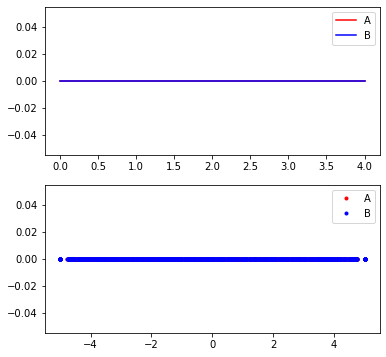

In [71]:
# Plot of the time-average spatial concentration.
x_vals = model.mesh.coordinates()[:, 0]
#A_vals = numpy.sum(result.get_species("A", concentration=False, debug=False), axis=0)
#B_vals = numpy.sum(result.get_species("B", concentration=False, debug=False), axis=0)
A_vals = numpy.sum(result.get_species("A", concentration=True, 
                                      debug=False), axis=0)
B_vals = numpy.sum(result.get_species("B", concentration=True, 
                                      debug=False), axis=0)

A_sum = numpy.sum(result.get_species("A"), axis=1)
B_sum = numpy.sum(result.get_species("B"), axis=1)
print(A_sum[-1])
print(B_sum[-1])
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.plot(result.get_timespan(),A_sum,'-r',label="A")
plt.plot(result.get_timespan(),B_sum,'-b',label="B")
plt.legend(loc='best')
plt.subplot(2,1,2)

vol = model.mesh.vol
type = model.mesh.type
print(numpy.sum(vol[type == 2]))
print(numpy.sum(vol[type == 3]))


plt.plot(x_vals,A_vals,'.r',x_vals,B_vals,'.b')
plt.legend(['A', 'B'],loc='best')


In [ ]:
def plot_step(t_ndx,key='type'):
    pts, data = result.read_step(t_ndx)
    plt.figure(figsize=(15,10) )
    plt.scatter(pts[:,0],pts[:,1],c=data[key])
    plt.axis('equal')
    plt.colorbar()
    plt.title('t={0}'.format(t_ndx))

In [ ]:
plot_step(0,'id')

In [ ]:
plot_step(0)

In [ ]:
plot_step(2,'C[A]')

In [ ]:
t=200
plot_step(t,'D[A]')
plot_step(t,'D[B]')

In [ ]:
# Plot the subdomains
result.plot_property("type", 2)

In [ ]:
result.plot_species("A", t_ndx=-1, deterministic=True)

In [ ]:
result.plot_species("A", t_ndx=-1, size=10)

In [ ]:
result.plot_property("type", use_matplotlib=True, mpl_width=15, mpl_height=10)

In [ ]:
result.plot_species("A", deterministic=True, use_matplotlib=True, mpl_width=15, mpl_height=10)

In [ ]:
result.plot_species("A", use_matplotlib=True, mpl_width=15, mpl_height=10)

In [ ]:
#from spatialpy.Solver import Solver
#sol = Solver(model, debug_level=2)
#%time sol.compile()


In [ ]:
#sol.build_dir

In [ ]:
#print(subprocess.getoutput(sol.build_dir+'/ssa_sdpd'))

In [ ]:
#!/tmp/spatialpy_build_1h9cf_2u/ssa_sdpd